The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# RMSProp
:label:`sec_rmsprop`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[改进](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html))

:numref:`sec_adagrad` 中的关键问题之一是，学习率按预定时间表实际上是 $\mathcal{O}(t^{-\frac{1}{2}})$ 降低。虽然这通常适用于凸问题，但对于非凸问题，例如深度学习中遇到的问题，可能并不理想。但是，作为预调器，Agrad 的坐标适应性是非常可取的。

:cite:`Tieleman.Hinton.2012` 建议使用 rmsProp 算法，作为将速率调度与坐标自适应学习率分离的简单修复方法。问题在于，Agrad 将梯度 $\mathbf{g}_t$ 的平方积累成状态矢量 $\mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2$。因此，由于缺乏规范化，$\mathbf{s}_t$ 继续增长，没有约束力，基本上是在算法收敛时线性增长。

解决这个问题的一种方法是使用 $\mathbf{s}_t / t$。对于 $\mathbf{g}_t$ 的合理发行版，这将收敛。遗憾的是，限制行为可能需要很长时间，因为程序记住了价值的完整轨迹。另一种替代方法是按动量法中使用的方式使用漏平均值，即对于某些参数 $\gamma > 0$，对于某些参数 $\gamma > 0$，则使用 $\mathbf{s}_t \leftarrow \gamma \mathbf{s}_{t-1} + (1-\gamma) \mathbf{g}_t^2$。保持所有其他零件不变会产生 rmsProp。

## 该算法

让我们详细写出这些方程式。

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

常数 $\epsilon > 0$ 通常设置为 $10^{-6}$，以确保我们不会因零或过大的步长而受到除法的影响。鉴于这种扩展，我们现在可以自由控制 $\eta$ 的学习率，而不考虑基于每个坐标应用的缩放。就泄漏平均值而言，我们可以采用与之前在动量方法中适用的相同推理。扩大 $\mathbf{s}_t$ 收益率的定义

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

和以前在 :numref:`sec_momentum` 一样，我们使用了 $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$。因此，权重总和标准化为 $1$，观测值的半衰期为 $\gamma^{-1}$。让我们想象一下 $\gamma$ 各种选择的过去 40 个时间步长的权重。


In [1]:
import math
import tensorflow as tf
from d2l import tensorflow as d2l


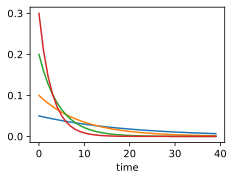

In [2]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = tf.range(40).numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time');

## 从头开始实施

和之前一样，我们使用二次函数 $f(\mathbf{x})=0.1x_1^2+2x_2^2$ 来观察 rmsProp 的轨迹。回想一下，在 :numref:`sec_adagrad` 中，当我们使用学习率为 0.4 的 Agrad 时，变量在算法的后期阶段移动非常缓慢，因为学习率下降太快。由于 $\eta$ 是单独控制的，RMSProp 不会发生这种情况。


epoch 20, x1: -0.010599, x2: 0.000000


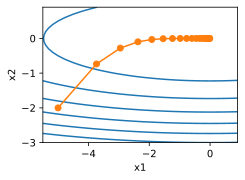

In [3]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

接下来，我们实施 rmsProp 以在深度网络中使用。这同样简单明了。


In [4]:
def init_rmsprop_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

In [5]:
def rmsprop(params, grads, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(gamma * s + (1 - gamma) * tf.math.square(g))
        p[:].assign(p - hyperparams['lr'] * g / tf.math.sqrt(s + eps))

我们将初始学习率设置为 0.01，加权期 $\gamma$ 设置为 0.9。也就是说，在过去的 $1/(1-\gamma) = 10$ 次平方梯度观测值中，平均为 $\mathbf{s}$。


loss: 0.249, 0.074 sec/epoch


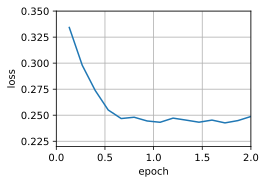

In [6]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## 简洁的实施

由于 rmsProp 是一种相当受欢迎的算法，它也可以在 `Trainer` 实例中使用。我们所需要做的就是使用名为 `rmsprop` 的算法实例化它，将 $\gamma$ 分配给参数 `gamma1`。


loss: 0.243, 0.097 sec/epoch


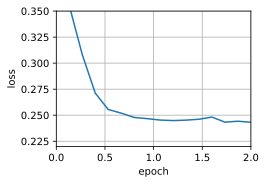

In [7]:
trainer = tf.keras.optimizers.RMSprop
d2l.train_concise_ch11(trainer, {'learning_rate': 0.01, 'rho': 0.9},
                       data_iter)

## 摘要

* rmsProp 与 Agrad 非常相似，因为两者都使用梯度的平方来缩放系数。
* RMSProp 股票的势头是泄漏的平均值。但是，rmsProp 使用该技术来调整系数明智的预调器。
* 实践中，学习率需要由实验者安排。
* 系数 $\gamma$ 决定了调整每坐标比例时历史记录的时间。

## 练习

1. 如果我们设置 $\gamma = 1$，实验会发生什么？为什么？
1. 旋转优化问题以最大限度地减少 $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。融合会发生什么？
1. 尝试在真正的机器学习问题上 RMSProp 会发生什么，例如在 Fashion-MNIST 上的培训。尝试不同的选择来调整学习率。
1. 随着优化的进展，你想调整 $\gamma$ 吗？RMSProp 对此有多敏感？


[Discussions](https://discuss.d2l.ai/t/1075)
